In [150]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets 

from unet import UNet

#hypterparameter 설정
lr = 1e-3
batch_size=4
num_epoch=50

data_dir ='./unet_week3/data'
ckpt_dir ='./checkpoint'
log_dir='./log'
result_dir = './results'

if not os.path.exists(result_dir):
    os.makedirs(result_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#데이터 로더 구현
class Dataset(torch.utils.data.Dataset):
    def __init__(self,data_dir,transform=None): #argument 값 선언 
        self.data_dir = data_dir
        self.transform = transform
        
        lst_data = os.listdir(self.data_dir)
        
        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]
        
        lst_label.sort()
        lst_input.sort()
        
        self.lst_label = lst_label
        self.lst_input = lst_input
        
    def __len__(self): #data length 확인
        return len(self.lst_label)
    
    def __getitem__(self, index): #데이터 불러오기 
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        
        label = label/255.0
        input = input/255.0
 
        if label.ndim ==2:
            label=label[:,:,np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]
        
        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data

class ToTensor(object):
    def __call__(self,data):
        label, input = data['label'], data['input']
        
        label = label.transpose((2,0,1)).astype(np.float32) 
        input = input.transpose((2,0,1)).astype(np.float32)
        
        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

#train : -1(어두운 부분) ~ 1(밝은 부분) 사이의 범위를 갖는다.
#label : 0(어두운 부분) ~ 1(밝은 부분)
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        #라벨은 건들 ㄴㄴ
        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label) #오왼 반전 
            input = np.fliplr(input)
        
        #50% 확률로
        if np.random.rand() > 0.5:
            label = np.flipud(label) #위아래 반전
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

# 훈련을 위한 Transform과 DataLoader 불러오기
transform = transforms.Compose([Normalization(mean=0.5, std=0.5),  ToTensor()])

# num_workers : GPU 대수 * 4
dataset_test = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)


# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

#손실 함수 정의
#Sigmoid layer + BCELoss(Binaray Classification)의 조합
# 1 or 0이 나오도록
#https://cvml.tistory.com/26
fn_loss = nn.BCEWithLogitsLoss().to(device)

#Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(),lr=lr)

#추가 설정
num_data_test= len(dataset_test)

num_batch_test= np.ceil(num_data_test/batch_size)

# 그 밖에 부수적인 functions 설정하기
#tensor에서 numpy로
#batch, channel, y, x -> batch, y,x,channel 
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
#denormalize
fn_denorm = lambda x, mean, std: (x * std) + mean
#binary class 기준 설정
fn_class = lambda x: 1.0 * (x > 0.5)

#네트워크 저장
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
        
    torch.save({'net': net.state_dict(), 'optim': optim.state_dict(),},
               './%s/model_epoch%d.pth'% (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch
        
 

In [151]:
print(dataset_test)

In [152]:

# data_dir의 경로(문자열)와 train(문자열)을 결합해서 train_dir(train 폴더의 경로)에 저장합니다.
train_dir = os.path.join(data_dir, "train")

# data_dir의 경로(문자열)와 val(문자열)을 결합해서 val_dir(val 폴더의 경로)에 저장합니다.
val_dir = os.path.join(data_dir, "val")

In [153]:
# train_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 train_fns에 저장합니다.
train_fns = os.listdir(train_dir)

# val_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 val_fns에 저장합니다.
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

48 6


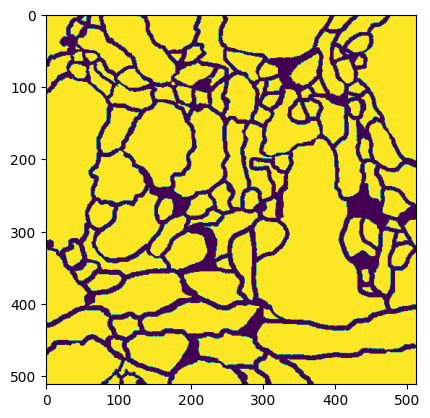

In [154]:
sample_image_fp = os.path.join(train_dir, train_fns[0])

sample_image = np.load(sample_image_fp)

plt.imshow(sample_image)
plt.show()

In [155]:
sample_image.shape

(512, 512)

In [156]:
to_tensor = transforms.ToTensor()
sample_image_tensor = to_tensor(sample_image)

In [157]:
sample_image_tensor.shape

torch.Size([1, 512, 512])

In [158]:
import torch
import numpy as np

#(1, x, y)
def mirroring_Extrapolate(img):
    x = img.shape[1]
    y = img.shape[2]

    np_img = np.array(img)

    np_img = np_img[0]
    
    #####가로######
    if x < 388:
        pad_x_left = (572 - x) / 2
        pad_x_right = (572 - x) / 2
    else:
        pad_x_left = 92
        pad_x_right = 388 - (x % 388) + 92

    #####세로######
    if y < 388:
        pad_y_up = (572 - y) / 2
        pad_y_down = (572 - y) / 2
    else:
        pad_y_up = 92
        pad_y_down = 388 - (y % 388) + 92





    np_img = np.pad(np_img, ((pad_x_left, pad_x_right), (pad_y_up, pad_y_down)), 'reflect')

    np_img = np_img[:, :, np.newaxis]

    return torch.from_numpy(np_img.transpose((2, 0, 1)))

<ipython-input-159-4590960d94af>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_image_mirror = mirroring_Extrapolate(torch.tensor(sample_image_tensor))


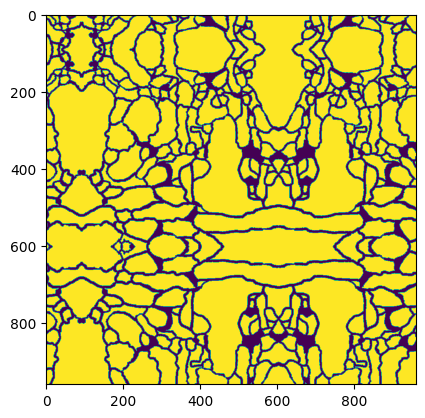

In [159]:
sample_image_mirror = mirroring_Extrapolate(torch.tensor(sample_image_tensor))
sample_image_mirror = sample_image_mirror.squeeze()
plt.imshow(sample_image_mirror)
plt.show()

In [160]:
sample_image_mirror.shape

torch.Size([960, 960])

In [161]:
sample_image_mirror

tensor([[1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [162]:
sample_image_mirror_with_channel = sample_image_mirror.view(1, sample_image_mirror.size(0), sample_image_mirror.size(1))

In [163]:
sample_image_mirror_with_channel.shape

torch.Size([1, 960, 960])

In [164]:
def split_image(image):
    image = np.array(image)
    image_1, image_2, image_3, image_4 = (image[:, :480, 480:],
                                          image[:, 480:, 480:],
                                          image[:, :480, :480],
                                          image[:, 480:, :480])
    return image_1, image_2, image_3, image_4

def concat_image(*images):


    images = [np.array(image) for image in images]
    

    top_concat = np.concatenate((images[0], images[1]), axis=1)
    bottom_concat = np.concatenate((images[2], images[3]), axis=1)
    

    concatenated_image = np.concatenate((top_concat, bottom_concat), axis=2)
    
    return concatenated_image

In [165]:
sample_image_tensor_split = split_image(sample_image_mirror_with_channel)
for i in range(0,4):
    print(sample_image_tensor_split[i].shape)


(1, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 480, 480)


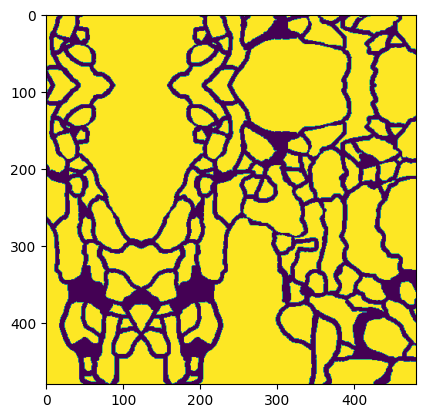

In [166]:

sample_image_mirror_plt = sample_image_tensor_split[0].squeeze()
plt.imshow(sample_image_mirror_plt)
plt.show()

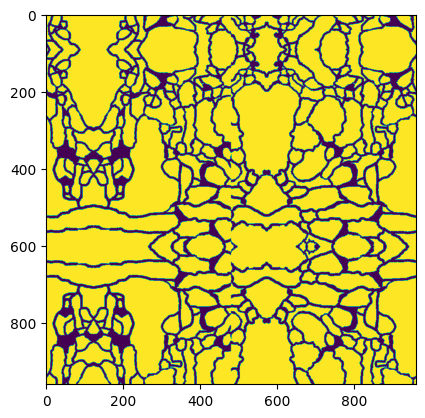

In [167]:
lst = []

for i in range(0,4):
    lst.append(sample_image_tensor_split[i])


concatenated_image = concat_image(*lst)

a = torch.tensor(concatenated_image)
a = a.squeeze()

plt.imshow(a)
plt.show()

In [168]:

## 네트워크 구조
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # conv, BN, ReLU == 파란색 화살표
        def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, bias = True):
            layers = []
            layers += [nn.Conv2d(in_channels = in_channels,
                                out_channels = out_channels,
                                kernel_size = kernel_size,
                                stride = stride,
                                padding = None,
                                bias = bias)] # conv layer 정의

            layers += [nn.BatchNorm2d(num_features=out_channels)] # BN layer 정의
            layers += [nn.ReLU()] # ReLU layer 정의

            cbr = nn.Sequential(*layers)

            return cbr

        # contracting path / contract{stage}_{layer의 index}
        self.contract1_1 = CBR2d(in_channels=1, # 흑백이다.
                            out_channels=64) # 첫번째 파란색 화살표

                            
                            #kernel_size=3,stride=1,padding=1,bias=True => 함수에서 미리 정의
                            
        self.contract1_2 = CBR2d(in_channels=64,out_channels=64)  # 첫번째 layer의 두번째 파란색 화살표
        
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 첫번째 빨간색 화살표

        self.contract2_1 = CBR2d(in_channels=64,out_channels=128)
        self.contract2_2 = CBR2d(in_channels=128,out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.contract3_1 = CBR2d(in_channels=128,out_channels=256)
        self.contract3_2 = CBR2d(in_channels=256,out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.contract4_1 = CBR2d(in_channels=256,out_channels=512)
        self.contract4_2 = CBR2d(in_channels=512,out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2) # 가장 아래 stage까지 내려옴.

        self.contract5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path

        self.expansive5_1  = CBR2d(in_channels=1024, out_channels=512)

        self.upconv4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)
                                          
        self.expansive4_2 = CBR2d(in_channels=2*512, out_channels=512) # 스킵커넥션
        self.expansive4_1 = CBR2d(in_channels=512, out_channels=256)

        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.expansive3_2 = CBR2d(in_channels=2*256, out_channels=256) # 스킵커넥션
        self.expansive3_1 = CBR2d(in_channels=256, out_channels=128)

        self.upconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.expansive2_2 = CBR2d(in_channels=2*128, out_channels=128) # 스킵커넥션
        self.expansive2_1 = CBR2d(in_channels=128, out_channels=64)

        self.upconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.expansive1_2 = CBR2d(in_channels=2*64, out_channels=64) # 스킵커넥션
        self.expansive1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True) # 녹색화살표

    def forward(self,x): # 이제 모든 걸 다 연결해보겠다. x는 인풋이미지
            
        contract1_1=self.contract1_1(x) # (1,572,572)->(64,570,570)
        contract1_2=self.contract1_2(contract1_1) # (64,570,570)->(64,568,568)
        pool1=self.pool1(contract1_2) # (64,568,568)->(64,284,284)
        
        contract2_1=self.contract2_1(pool1) # (64,284,284)->(128,282,282)
        contract2_2=self.contract2_2(contract2_1) # (128,282,282)->(128,280,280)
        pool2=self.pool2(contract2_2) # (128,280,280)->(128,140,140)
        
        contract3_1=self.contract3_1(pool2) # (128,140,140)->(256,138,138)
        contract3_2=self.contract3_2(contract3_1) # (256,138,138)->(256,136,136)
        pool3=self.pool3(contract3_2) # (256,136,136)->(256,68,68)
        
        contract4_1=self.contract4_1(pool3) # (256,68,68)->(512,66,66)
        contract4_2=self.contract4_2(contract4_1) # (512,66,66)->(512,64,64)
        pool4=self.pool4(contract4_2) # (512,64,64)->(512,32,32)
        
        contract5_1=self.contract5_1(pool4) # (512,32,32)->(1024,30,30)
        
        expansive5_1= self.expansive5_1(contract5_1) # (1024,30,30)->(1024,28,28)

        #### 가장 하위 stage4에서 다음 스테이지까지의 과정
        upconv4=self.upconv4(expansive5_1) # (1024,28,28)->(512,56,56)

        concat4 = torch.cat((upconv4, contract4_2), dim = 1) #(512,56,56) + (512,56,56) = (1024,56,56)
        # 채널방향으로 concat => cat이라고 한다~
        # dim = [0:batch, 1:channel, 2:height(y방향), 3:width(x방향)]
        expansive4_2 = self.expansive4_2(concat4) # (1024,56,56)->(512,54,54)
        expansive4_1 = self.expansive4_1(expansive4_2) # (512,54,54)->(512,52,52)

        upconv3 = self.upconv3(expansive4_1) # (512,52,52)->(256,104,104)
        concat3 = torch.cat((upconv3, contract3_2), dim=1) # (256,104,104) + (256,104,104) = (512,104,104)
        expansive3_2 = self.expansive3_2(concat3) # (512,104,104)->(256,102,102)
        expansive3_1 = self.expansive3_1(expansive3_2) # (256,102,102)->(256,100,100)

        upconv2 = self.upconv2(expansive3_1) # (256,100,100)->(128,200,200)
        concat2 = torch.cat((upconv2, contract2_2), dim=1) # (128,200,200) + (128,200,200) = (256,200,200)
        expansive2_2 = self.expansive2_2(concat2) # (256,200,200)->(128,198,198)
        expansive2_1 = self.expansive2_1(expansive2_2) # (128,198,198)->(128,196,196)

        upconv1 = self.upconv1(expansive2_1) # (128,196,196)->(64,392,392)
        concat1 = torch.cat((upconv1, contract1_2), dim=1) # (64,392,392) + (64,392,392) = (128,392,392)
        expansive1_2 = self.expansive1_2(concat1) # (128,392,392)->(64,390,390)
        expansive1_1 = self.expansive1_1(expansive1_2) # (64,390,390)->(64,388,388)

        x = self.fc(expansive1_1) # (64,388,388)->(1,388,388)

        return x # (1, 388, 388)


In [169]:
unet = UNet()

In [171]:
isinstance(to_tensor(sample_image_tensor_split[0]), np.ndarray)

False

In [ ]:
k = to_tensor()
k.shape

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

In [ ]:
for i in range(0,4):
    a = model_unet(torch.tensor(sample_image_tensor_split[i]).unsqueeze(0))
    lst.append(a)

concatenated_image = concat_image(*lst)

plt.imshow(concatenated_image)
plt.show()

TypeError: conv2d() received an invalid combination of arguments - got (Tensor, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (NoneType, NoneType)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (NoneType, NoneType)!, !tuple of (int, int)!, int)


In [ ]:
lst = []

for i in range(0,4):
    a = model_unet(sample_image_tensor_split[i])
    lst.append(a)


concatenated_image = concat_image(*lst)

a = torch.tensor(concatenated_image)
a = a.squeeze()

plt.imshow(a)
plt.show()

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (NoneType, NoneType)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (NoneType, NoneType)!, !tuple of (int, int)!, int)


In [ ]:


transform = transforms.Compose([Normalization(mean=0.5, std=0.5),  ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)

#Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(),lr=lr)

#추가 설정
num_data_test= len(dataset_test)

num_batch_test= np.ceil(num_data_test/batch_size)

# 그 밖에 부수적인 functions 설정하기
#tensor에서 numpy로
#batch, channel, y, x -> batch, y,x,channel 
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
#denormalize
fn_denorm = lambda x, mean, std: (x * std) + mean
#binary class 기준 설정
fn_class = lambda x: 1.0 * (x > 0.5)

#네트워크 저장
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
        
    torch.save({'net': net.state_dict(), 'optim': optim.state_dict(),},
               './%s/model_epoch%d.pth'% (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch
        
    

#네트워크 학습
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          
print("LOSS %.4f" %
        (np.mean(loss_arr)))
